# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import wrangle as w
import explore_mod as em

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Project Description

The aim of this project is to look at what drives customer churn for a fictional company, Telco.

The main goals are:

- Determine at least two factors that contribute to customer churn.
- Predict with at least 80% accuracy whether a given customer will churn.
- Provide stakeholders with recommendations as to how to reduce customer churn.

## Hypothesis:

> monthly_charges and tenure are the most determining factors of whether a customer will churn.

# Data Wrangling

First, we'll get our data from the database. The function will save a local copy.

In [2]:
telco = w.get_telco_data()

telco.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,1,2,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


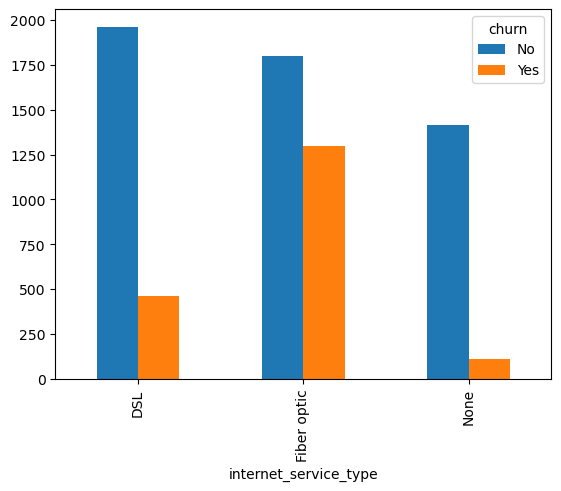

In [3]:
pct = pd.crosstab(telco.internet_service_type, telco.churn)
pct.plot.bar()
plt.show()

In [4]:
pd.crosstab(telco.internet_service_type, telco.churn, margins=True)

churn,No,Yes,All
internet_service_type,,,
DSL,1962,459,2421
Fiber optic,1799,1297,3096
None,1413,113,1526
All,5174,1869,7043


Of those that don't have internet, 113 out of 1526 churn (7.4% within group, 1.6% of total customers).

Of those that do have internet, 1756 out of 5517 churn (31.83% within group, 24.93% of total customers).

**I will isolate the dataset to only contain those who have internet, and predict their churn.**

Next, we'll run our data through a function that will handle null values and format the data for easy exploration and modeling.

In [5]:
telco = w.prep_telco(telco) 

# total_charges had 'sneaky' nulls (a space saved as a string), which were replaced with 0s and converted to dtype float.

telco.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,payment_type,gender_Male,multiple_lines_1,multiple_lines_No phone service,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
customer_id,,,,,,,,,,,,,,,,,,,,,
0002-ORFBO,Female,0,1,1,9,1,0,0,1,0,...,Mailed check,0,0,0,1,0,0,0,0,1
0003-MKNFE,Male,0,0,0,9,1,1,0,0,0,...,Mailed check,1,1,0,0,0,0,0,0,1
0004-TLHLJ,Male,0,0,0,4,1,0,0,0,1,...,Electronic check,1,0,0,0,0,1,0,1,0
0011-IGKFF,Male,1,1,0,13,1,0,0,1,1,...,Electronic check,1,0,0,0,0,1,0,1,0
0013-EXCHZ,Female,1,1,0,3,1,0,0,0,0,...,Mailed check,0,0,0,0,0,1,0,0,1


Finally, we'll split the data into a train, validate, and test set, and continue our exploration, hypothesis testing, and modeling on the training dataset alone.

In [6]:
train_telco, validate_telco, test_telco = w.split_data(telco, 'churn')

train_telco.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,payment_type,gender_Male,multiple_lines_1,multiple_lines_No phone service,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
customer_id,,,,,,,,,,,,,,,,,,,,,
3474-BAFSJ,Male,0,1,0,57,0,No phone service,0,1,1,...,Bank transfer (automatic),1,0,1,0,1,0,0,0,0
6599-RCLCJ,Male,0,1,0,47,1,1,0,1,1,...,Electronic check,1,1,0,0,0,1,0,1,0
4631-OACRM,Male,1,0,0,15,1,0,0,0,0,...,Electronic check,1,0,0,0,0,1,0,1,0
2867-UIMSS,Male,0,0,0,1,1,0,0,0,0,...,Electronic check,1,0,0,0,0,1,0,1,0
9842-EFSYY,Female,0,0,1,4,0,No phone service,1,1,1,...,Mailed check,0,0,1,0,0,0,0,0,1


# Data Exploration

We will look at the following variables:

- tenure
- monthly_charges
- online_security
- tech_support
- contract_type
- payment_type

1) Does tenure affect whether a customer will churn?

TENURE


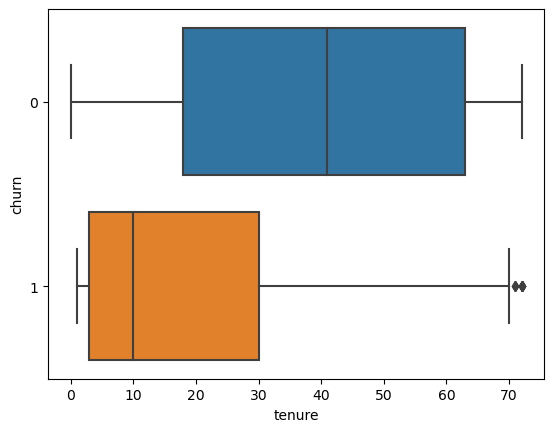


Stats results for tenure vs churn:

Stat value: 1782203.0
P-value: 4.214882008010433e-119



In [8]:
em.get_variable_viz(train_telco, 'tenure')

In [16]:
telco[telco.churn == 1].tenure.median()

10.0

Yes, we can state that tenure affects whether a customer will churn. On average, 50% of customers that will churn will churn around the 12-month mark.

2) Do monthly_charges affect whether a customer will churn?

MONTHLY_CHARGES


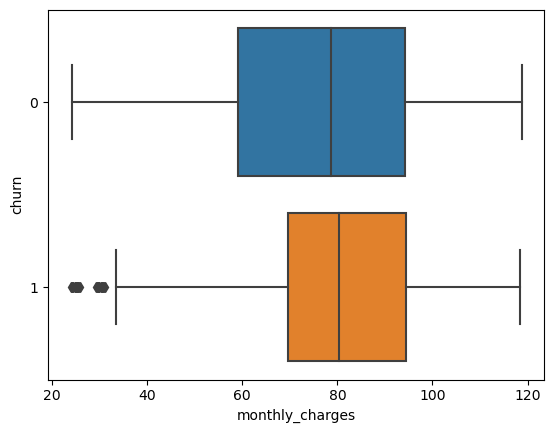


Stats results for monthly_charges vs churn:

Stat value: 1127920.5
P-value: 0.018203216295552393



In [9]:
em.get_variable_viz(train_telco, 'monthly_charges')

In [10]:
# To get average difference in how much people pay per month.

(telco[telco.churn == 1].monthly_charges.mean() - telco[telco.churn == 0].monthly_charges.mean())

1.579453686043962

Even though p-value is smaller than usual $\alpha$ = .05, I will drop this from my features. Note that on average, those who churn only pay $1.57 more per month. P-value must be small because of size of dataset.

3) Does online_security affect whether a customer will churn?

In [ ]:
3) Does online_security affect whether a customer will churn

3) Does contract_type affect whether a customer will churn?

CONTRACT_TYPE


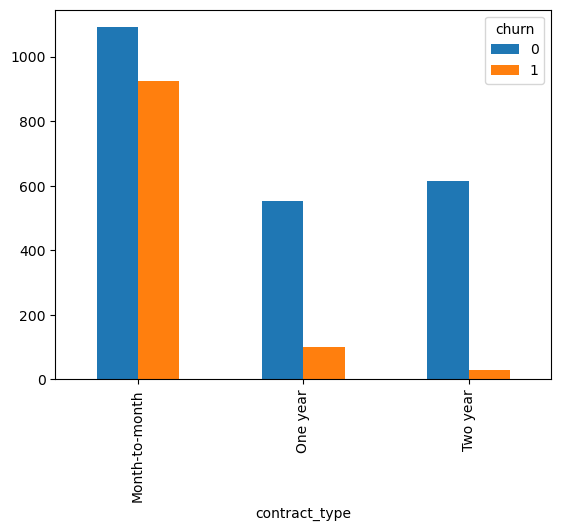


Stats results for contract_type vs churn:

Chi^2 value: 483.4465626663888
P-value: 1.04933164316652e-105



In [11]:
em.get_variable_viz(train_telco, 'contract_type')

Yes, we can state that contract type affects whether a customer will churn.

4) Does internet_service_type affect whether a customer will churn?

INTERNET_SERVICE_TYPE


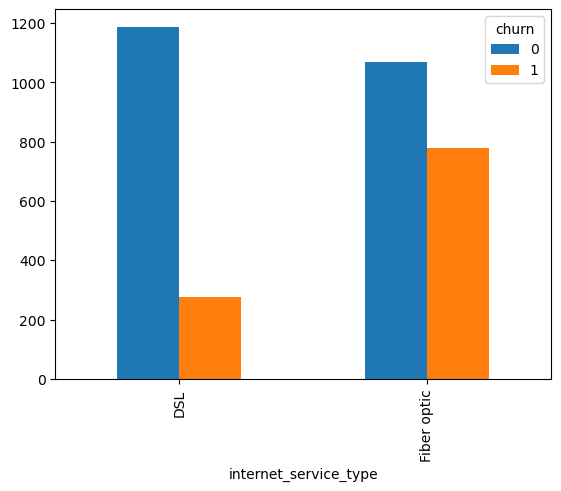


Stats results for internet_service_type vs churn:

Chi^2 value: 204.19087946711312
P-value: 2.5429294769258776e-46



In [12]:
em.get_variable_viz(train_telco, 'internet_service_type')

Yes, we can state that internet service type affects whether a customer will churn.

# Key Findings

- All four variables explored affect the likelihood of a customer churning: tenure, monthly charges, contract type, and internet service type.
- The mean of tenure is 10 months for churned customers vs around 40 for those who don't churn.
- Fiber optic internet service has a much higher ratio of churn:no_churn among other services.
- Month-to-month contract type is most susceptible to churn.
- Customers who churn pay, on average, around $\$$15 more per month.
- 7.40% of customers with no internet churn vs. 31.83% of customers with internet
- Among those who have internet, customers who churn pay an average of $1.57 more than those who don't per month.

# Data Modeling

We'll run the features we identified to affect churn into different classification models.

### Setting a baseline

In [9]:
train_telco.churn.value_counts()

0    3104
1    1121
Name: churn, dtype: int64

Baseline accuracy to beat in our models is 3104/(3104+1121) = 73.48%

### Splitting our dataset into the features we need to send into our model.

In [10]:
X_train = train_telco[['tenure', 'monthly_charges', 'contract_type_One year', 'contract_type_Two year', 'internet_service_type_Fiber optic', 'internet_service_type_None']]
y_train = train_telco.churn

X_validate = validate_telco[['tenure', 'monthly_charges', 'contract_type_One year', 'contract_type_Two year', 'internet_service_type_Fiber optic', 'internet_service_type_None']]
y_validate = validate_telco.churn

X_test = test_telco[['tenure', 'monthly_charges', 'contract_type_One year', 'contract_type_Two year', 'internet_service_type_Fiber optic', 'internet_service_type_None']]
y_test = test_telco.churn

## Performance Check across all Classification Models

In [11]:
em.classification_models_performance(X_train, y_train, X_validate, y_validate)

,model,train,validate,hyper_value,difference
0,Decision Tree,0.807574,0.793471,6,0.014103
1,Random Forest,0.801420,0.799148,6,0.002272
2,KNN,0.813964,0.781405,8,0.032559
3,Logistic Regression,0.783905,0.792761,10,-0.008855


We'll go with Random Forest (depth=6) since it's least susceptible to overfit of data.

# Predictions

Using our chosen model, we'll cast predictions as to whether a customer will churn on our X_test, y_test dataset.

The results are saved in the predictions.csv file on the local directory.

In [16]:
rfc = RandomForestClassifier(max_depth=6, min_samples_leaf=5)

rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
y_prob = rfc.predict_proba(X_test)

predictions = pd.DataFrame({'customer_id': X_test.reset_index().customer_id, #reset_index since customer_id was set to index in prep
             'prediction': y_pred,
             'churn_prob': y_prob[:,1]})

predictions.to_csv('predictions.csv', index=False) # Saving to csv.

predictions.head() # Preview of csv file contents.

,customer_id,prediction,churn_prob
0,4531-AUZNK,0,0.196813
1,2296-DKZFP,0,0.055281
2,9692-TUSXH,0,0.499849
3,5129-JLPIS,1,0.515813
4,1273-MTETI,1,0.654022


# Key Findings, Takeaways, and Recommendations

- All four variables explored affect the likelihood of a customer churning: tenure, monthly charges, contract type, and internet service type.
- We met our goal of predicting churn with 80% accuracy.


Next steps:
- We should look further into tech support as a likely factor.


Some recommendations for Telco:
- Invest in R&D for their Fiber Optic service.
- Offer incentives to customers once they hit the 10-month mark.